In [1]:
import pandas as pd
import os
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)


In [2]:
os.getcwd()

'C:\\Users\\User\\Documents\\GitHub\\Hypertension_prediction\\Hypertension(regularly sampled data)\\Codebase(previous paper codes)\\Hypertension_code_amy'

In [3]:
#df = pd.read_excel (r'Mappings.xlsx')
p9690 =pd.read_csv (r'./Output/missing_value_imputed/p9690_missing.csv')#,parse_dates=['Timestamp'], index_col=['Timestamp'])
p9630 =pd.read_csv (r'./Output/missing_value_imputed/p9630_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p9888 =pd.read_csv (r'./Output/missing_value_imputed/p9888_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p10049=pd.read_csv (r'./Output/missing_value_imputed/p10049_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p10412=pd.read_csv (r'./Output/missing_value_imputed/p10412_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])

In [4]:
#!git clone https://github.com/caow13/BRITS.git

In [5]:
#from sklearn.impute import KNNImputer
#p10049_knn_imputed = p10049.copy(deep=True)
#knn_imp = KNNImputer(n_neighbors=3)
#p10049_knn_imputed.loc[:, :] = knn_imp.fit_transform(p10049_knn_imputed)


first create patient train test set

In [6]:
p10049['Timestamp'] = pd.to_datetime(p10049['Timestamp'])
p10049['DOB'] = pd.to_datetime(p10049['DOB'])
p10049.set_index('Timestamp', inplace=True)

In [7]:
p10049.dtypes

UserID               float64
Systolic             float64
Diastolic            float64
Heart Rate           float64
DOB           datetime64[ns]
Weight               float64
Height               float64
Gender                object
dtype: object

In [8]:
p10049_s= p10049['Systolic']
p10049_d= p10049['Diastolic']
p10049_hr= p10049['Heart Rate']
p10049_all= p10049[['Systolic','Diastolic','Heart Rate']]
p10049_s_train,p10049_s_test= np.split(p10049_s, [int(.7 *len(p9690))])
p10049_d_train,p10049_d_test= np.split(p10049_d, [int(.7 *len(p9690))])
p10049_hr_train,p10049_hr_test= np.split(p10049_hr, [int(.7 *len(p9690))])
p10049_all_train,p10049_all_test= np.split(p10049_all, [int(.7 *len(p9690))])



interpolation

In [9]:
df_poly_imputed = p10049_all.interpolate(method='polynomial', order=5)
df_time_imputed = p10049_all.interpolate(method='time')
df_spline_imputed = p10049_all.interpolate(method='spline', order=5)
df_barycentric_imputed = p10049_all.interpolate(method='barycentric', order=2)


KNN Inputation

In [10]:
# Imputing with KNNImputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#Define a subset of the dataset
df_knn = p10049_all.copy()
#p9690.filter(['Systolic','Diastolic','Heart Rate'], axis=1).copy()


# Define scaler to set values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)


Multivariate Imputation by Chained Equations (MICE)

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

df_mice = p10049_all.copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

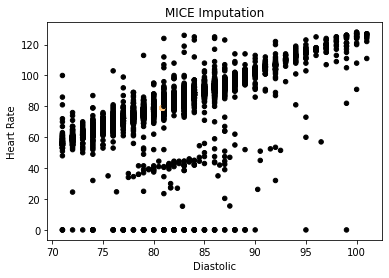

In [12]:
fig = plt.Figure()
null_values = p10049_all['Systolic'].isnull() 
fig = df_mice_imputed.plot(x='Diastolic', y='Heart Rate', kind='scatter', c=null_values, cmap='copper', title='MICE Imputation', colorbar=False)
#https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87#:~:text=Time%20Series%20Imputation&text=One%20way%20to%20impute%20missing,with%20the%20previously%20observed%20value

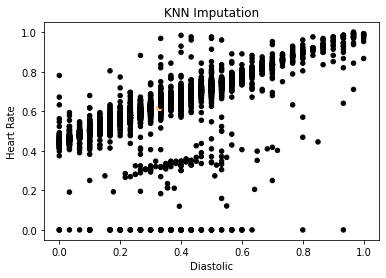

In [13]:
fig = plt.Figure()
null_values = p10049_all['Systolic'].isnull() 
fig = df_knn_imputed.plot(x='Diastolic', y='Heart Rate', kind='scatter', c=null_values, cmap='copper', title='KNN Imputation', colorbar=False)


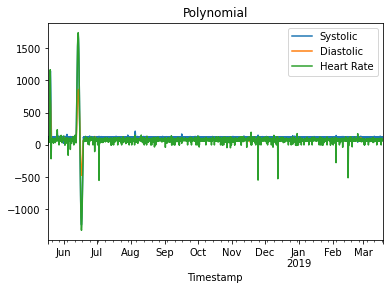

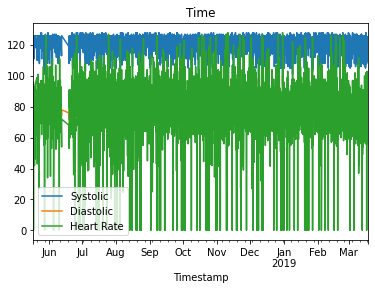

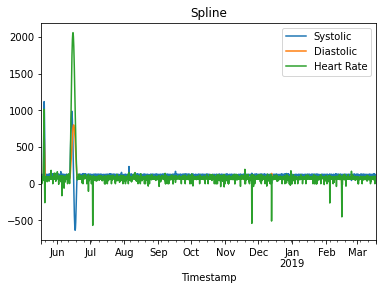

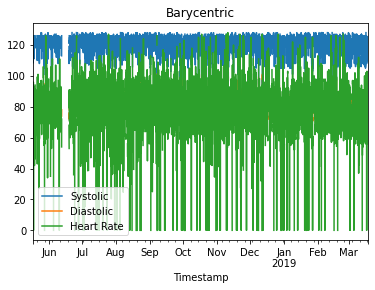

In [14]:
figsize=(40,15)
df_poly_imputed.plot(title='Polynomial')
df_time_imputed.plot(title='Time')
df_spline_imputed.plot(title='Spline')
df_barycentric_imputed.plot(title='Barycentric')
df_mice_imputed.plot(title='MICE')
df_knn_imputed.plot(title='KNN')
lines, labels = plt.gca().get_legend_handles_labels()
#labels = ['linear', 'time' ,'spline','barycentric']
plt.legend(lines, labels, loc='best')

In [15]:
!pip install adtk

In [16]:
from adtk.data import validate_series
#df_poly_imputed.index
df_time_imputed= validate_series(df_time_imputed)
print(df_time_imputed)

                       Systolic   Diastolic  Heart Rate
Timestamp                                              
2018-05-17 10:00:00  108.500000   72.000000   24.500000
2018-05-17 11:00:00  119.000000   76.000000   53.000000
2018-05-17 12:00:00  123.000000   81.000000   82.000000
2018-05-17 13:00:00  126.000000   87.000000   96.000000
2018-05-17 14:00:00  121.500000   80.000000   40.000000
2018-05-17 15:00:00  120.000000   79.000000   79.000000
2018-05-17 16:00:00  120.000000   79.000000    0.000000
2018-05-17 17:00:00  121.000000   80.000000   79.000000
2018-05-17 18:00:00  123.000000   77.000000   72.000000
2018-05-17 19:00:00  118.000000   79.000000   75.000000
2018-05-17 20:00:00  121.000000   80.000000   78.000000
2018-05-17 21:00:00  125.000000   86.000000   91.000000
2018-05-17 22:00:00  126.000000   86.000000   93.000000
2018-05-17 23:00:00  122.000000   77.000000   69.000000
2018-05-18 00:00:00  113.000000   74.000000   64.000000
2018-05-18 01:00:00  111.000000   73.000000   61

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

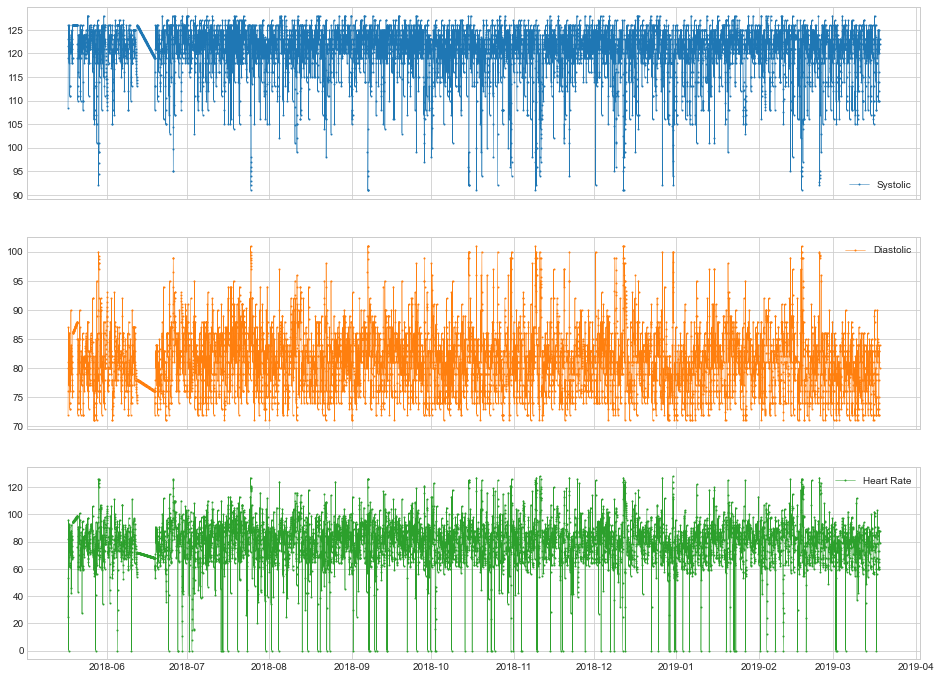

In [17]:
from adtk.visualization import plot
plot(df_time_imputed)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

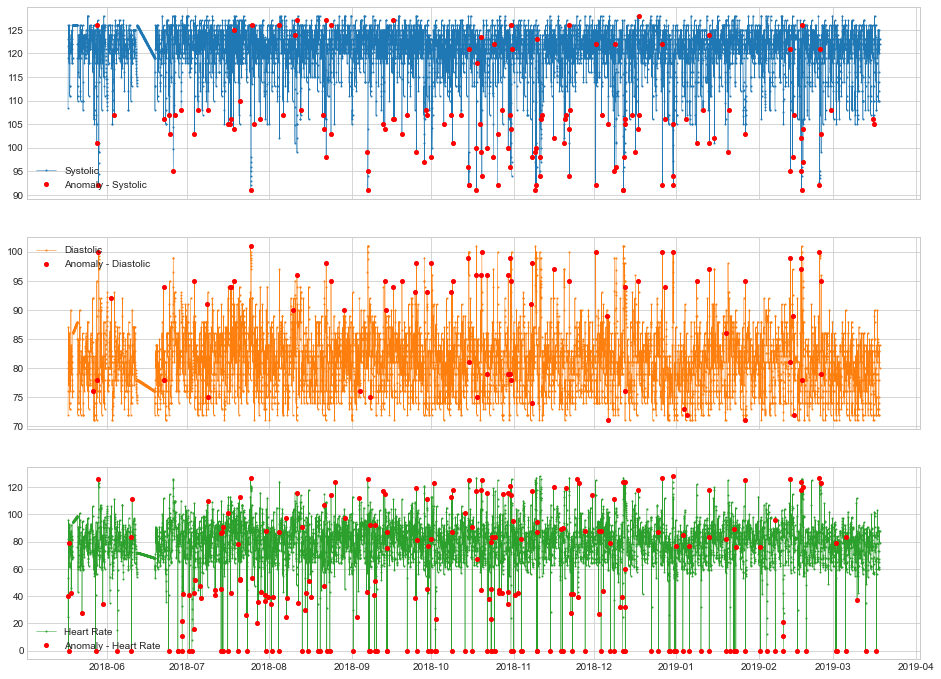

In [18]:
from adtk.detector import *
autoregression_ad = AutoregressionAD()
anomalies = autoregression_ad.fit_detect(df_time_imputed)
parameter = autoregression_ad.get_params()

plot(df_time_imputed, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

In [19]:
parameter

{'n_steps': 1,
 'step_size': 1,
 'regressor': LinearRegression(),
 'c': 3.0,
 'side': 'both'}

In [20]:
IQR_AD = InterQuartileRangeAD()
anomalies = IQR_AD.fit_detect(df_time_imputed)
plot(df_time_imputed, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

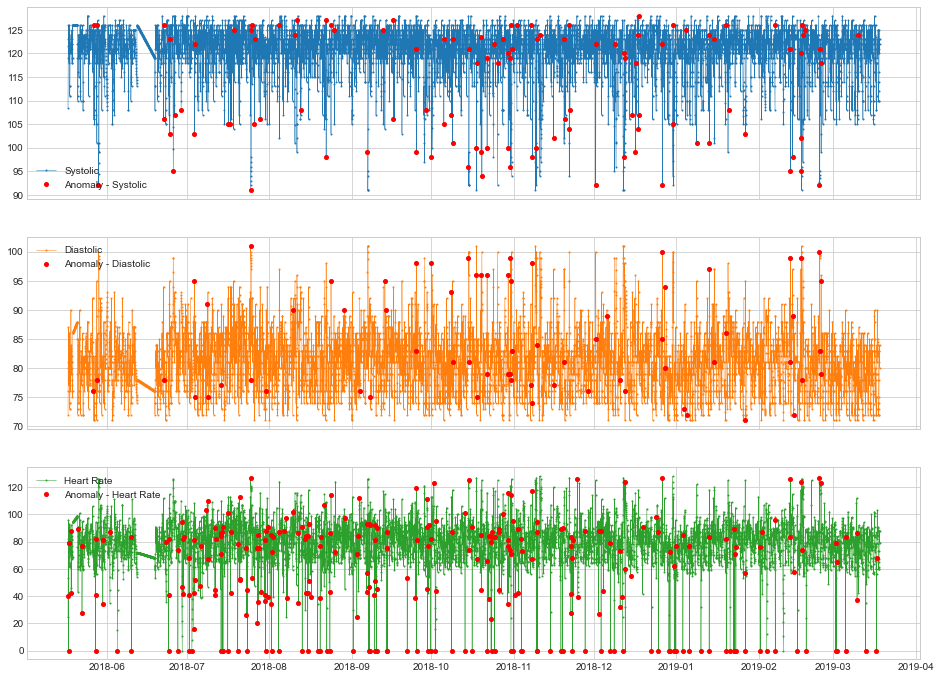

In [21]:
#compares time series values with the values of their preceding time windows, and identifies a time point as anomalous if the change of value from its preceding average or median is anomalously large
Persist_AD = PersistAD()
anomalies = Persist_AD.fit_detect(df_time_imputed)
#parameter = IQR_AD.get_params()
plot(df_time_imputed, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

#must seperate since cannot set threshold manually

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

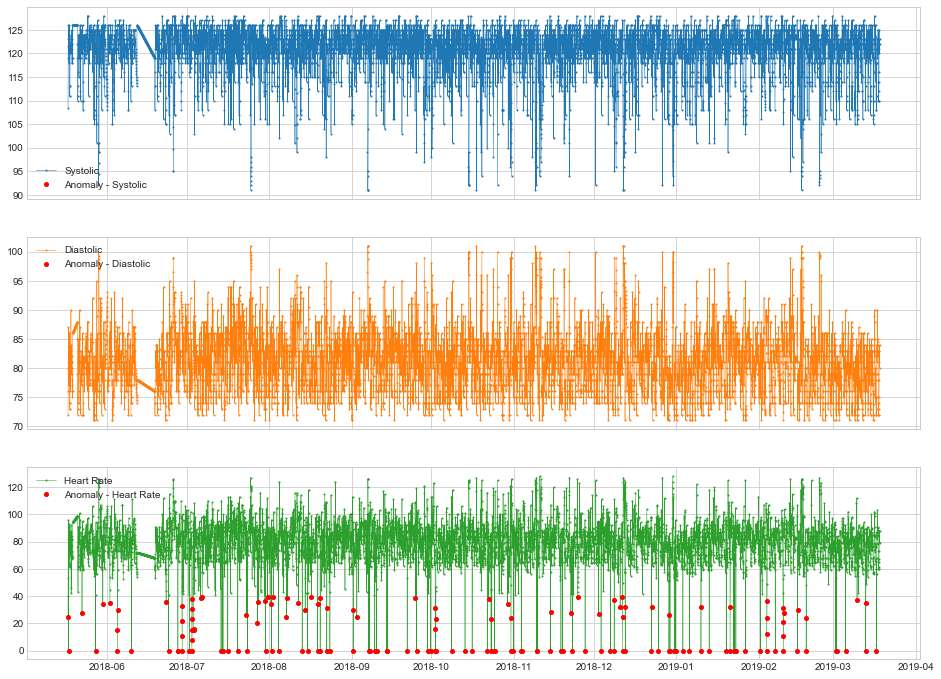

In [22]:
Threshold_AD = ThresholdAD(low=40, high=200)
anomalies = Threshold_AD.detect(df_time_imputed)
plot(df_time_imputed, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

In [23]:
#print_all_models()

Time series modelling

Vector Auto Regression (VAR)

In [24]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [25]:
df = df_time_imputed

In [26]:
df_bp = df[['Systolic','Diastolic']]

Granger’s Causality Test
test this relationship 

In [27]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=24
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False): 
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



In [28]:
grangers_causation_matrix(df, variables = df.columns)   

C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints 

Systolic_x  Diastolic_x  Heart Rate_x
Systolic_y           1.0          0.0           0.0
Diastolic_y          0.0          1.0           0.0
Heart Rate_y         0.0          0.0           1.0

In [29]:
df_bp

Systolic   Diastolic
Timestamp                                  
2018-05-17 10:00:00  108.500000   72.000000
2018-05-17 11:00:00  119.000000   76.000000
2018-05-17 12:00:00  123.000000   81.000000
2018-05-17 13:00:00  126.000000   87.000000
2018-05-17 14:00:00  121.500000   80.000000
2018-05-17 15:00:00  120.000000   79.000000
2018-05-17 16:00:00  120.000000   79.000000
2018-05-17 17:00:00  121.000000   80.000000
2018-05-17 18:00:00  123.000000   77.000000
2018-05-17 19:00:00  118.000000   79.000000
2018-05-17 20:00:00  121.000000   80.000000
2018-05-17 21:00:00  125.000000   86.000000
2018-05-17 22:00:00  126.000000   86.000000
2018-05-17 23:00:00  122.000000   77.000000
2018-05-18 00:00:00  113.000000   74.000000
2018-05-18 01:00:00  111.000000   73.000000
2018-05-18 02:00:00  111.000000   73.000000
2018-05-18 03:00:00  113.000000   74.000000
2018-05-18 04:00:00  121.000000   83.000000
2018-05-18 05:00:00  121.000000   79.500000
2018-05-18 06:00:00  121.000000   76.000000
2018-05-18 07:00:00  120.000000   83.000000
2018-05-18 08:00:00  121.000000   81.000000
2018-05-18 09:00:00  121.000000   80.000000
2018-05-18 10:00:00  123.000000   80.000000
2018-05-18 11:00:00  124.000000   82.000000
2018-05-18 12:00:00  122.000000   90.000000
2018-05-18 13:00:00  121.000000   83.000000
2018-05-18 14:00:00  122.500000   84.000000
2018-05-18 15:00:00  121.000000   83.000000
2018-05-18 16:00:00  120.000000   79.000000
2018-05-18 17:00:00  123.500000   83.500000
2018-05-18 18:00:00  123.000000   81.000000
2018-05-18 19:00:00  121.000000   80.000000
2018-05-18 20:00:00  125.000000   82.000000
2018-05-18 21:00:00  122.000000   81.000000
2018-05-18 22:00:00  118.000000   79.000000
2018-05-18 23:00:00  122.000000   77.000000
2018-05-19 00:00:00  118.000000   75.000000
2018-05-19 01:00:00  119.000000   76.000000
2018-05-19 02:00:00  126.000000   78.000000
2018-05-19 03:00:00  119.000000   76.000000
2018-05-19 04:00:00  126.000000   86.000000
2018-05-19 05:00:00  126.000000   86.048780
2018-05-19 06:00:00  126.000000   86.097561
2018-05-19 07:00:00  126.000000   86.146341
2018-05-19 08:00:00  126.000000   86.195122
2018-05-19 09:00:00  126.000000   86.243902
2018-05-19 10:00:00  126.000000   86.292683
2018-05-19 11:00:00  126.000000   86.341463
2018-05-19 12:00:00  126.000000   86.390244
2018-05-19 13:00:00  126.000000   86.439024
2018-05-19 14:00:00  126.000000   86.487805
2018-05-19 15:00:00  126.000000   86.536585
2018-05-19 16:00:00  126.000000   86.585366
2018-05-19 17:00:00  126.000000   86.634146
2018-05-19 18:00:00  126.000000   86.682927
2018-05-19 19:00:00  126.000000   86.731707
2018-05-19 20:00:00  126.000000   86.780488
2018-05-19 21:00:00  126.000000   86.829268
2018-05-19 22:00:00  126.000000   86.878049
2018-05-19 23:00:00  126.000000   86.926829
2018-05-20 00:00:00  126.000000   86.975610
2018-05-20 01:00:00  126.000000   87.024390
2018-05-20 02:00:00  126.000000   87.073171
2018-05-20 03:00:00  126.000000   87.121951
2018-05-20 04:00:00  126.000000   87.170732
2018-05-20 05:00:00  126.000000   87.219512
2018-05-20 06:00:00  126.000000   87.268293
2018-05-20 07:00:00  126.000000   87.317073
2018-05-20 08:00:00  126.000000   87.365854
2018-05-20 09:00:00  126.000000   87.414634
2018-05-20 10:00:00  126.000000   87.463415
2018-05-20 11:00:00  126.000000   87.512195
2018-05-20 12:00:00  126.000000   87.560976
2018-05-20 13:00:00  126.000000   87.609756
2018-05-20 14:00:00  126.000000   87.658537
2018-05-20 15:00:00  126.000000   87.707317
2018-05-20 16:00:00  126.000000   87.756098
2018-05-20 17:00:00  126.000000   87.804878
2018-05-20 18:00:00  126.000000   87.853659
2018-05-20 19:00:00  126.000000   87.902439
2018-05-20 20:00:00  126.000000   87.951220
2018-05-20 21:00:00  126.000000   88.000000
2018-05-20 22:00:00  122.000000   85.000000
2018-05-20 23:00:00  119.000000   79.000000
2018-05-21 00:00:00  116.000000   75.000000
2018-05-21 01:00:00  113.000000   74.000000
2018-05-21 02:00:00  110.000000   72.000000
2018-05-21 03:00:00

In [30]:
grangers_causation_matrix(df_bp, variables = df_bp.columns)   

C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints 

Systolic_x  Diastolic_x
Systolic_y          1.0          0.0
Diastolic_y         0.0          1.0

In [31]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Systolic ::  1498.78   > 24.2761   =>   True
Diastolic ::  614.85    > 12.3212   =>   True
Heart Rate ::  0.44      > 4.1296    =>   False


Spilt train test set

In [32]:
nobs = 96
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)  

(7226, 3)
(96, 3)


Stationarity test

In [33]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [34]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Systolic" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.8214
 No. Lags Chosen       = 32
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Diastolic" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.4256
 No. Lags Chosen       = 28
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Heart Rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significan

Since series is staionary can proceed to next step without differencing

In [35]:
model = VAR(df)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
    

Lag Order = 1
AIC :  10.537335946699445
BIC :  10.5486434219782
FPE :  37697.00574323929
HQIC:  10.541223556495455 

Lag Order = 2
AIC :  10.518412054114902
BIC :  10.53820244724961
FPE :  36990.3392382293
HQIC:  10.525216212591495 

Lag Order = 3
AIC :  10.514922312685838
BIC :  10.543197605699643
FPE :  36861.477620337864
HQIC:  10.524643741295389 

Lag Order = 4
AIC :  10.513126255036763
BIC :  10.54988843069645
FPE :  36795.33192507398
HQIC:  10.52576567551018 

Lag Order = 5
AIC :  10.512280224345304
BIC :  10.557531266161682
FPE :  36764.21546631544
HQIC:  10.527838358692174 

Lag Order = 6
AIC :  10.512085972746094
BIC :  10.565827864974377
FPE :  36757.07517128272
HQIC:  10.530563543254836 

Lag Order = 7
AIC :  10.508387610770278
BIC :  10.570622338410466
FPE :  36621.38598150363
HQIC:  10.529785340008276 

Lag Order = 8
AIC :  10.508636920157384
BIC :  10.57936646895465
FPE :  36630.51810773774
HQIC:  10.532955530971147 

Lag Order = 9
AIC :  10.508037862238986
BIC :  10.5872

In [36]:
x = model.select_order(maxlags=12)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

select lag 4 since it's the minimum

In [37]:
model_fitted = model.fit(4)
#model_fitted.summary()

In [38]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Systolic : 2.0
Diastolic : 2.0
Heart Rate : 2.0


The closer it is to the value 2, then there is no significant serial correlation

In [39]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = df.values[-lag_order:]
forecast_input

4


array([[123.,  81.,  80.],
       [121.,  83.,  88.],
       [122.,  84.,  88.],
       [123.,  80.,  79.]])

In [40]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns)
df_forecast

Systolic  Diastolic  Heart Rate
Timestamp                                             
2019-03-14 12:00:00  121.697679  80.379336   78.544614
2019-03-14 13:00:00  121.099829  80.439794   77.975566
2019-03-14 14:00:00  120.839244  80.398511   77.928269
2019-03-14 15:00:00  120.628307  80.538358   78.015804
2019-03-14 16:00:00  120.520433  80.635926   78.154296
2019-03-14 17:00:00  120.465719  80.715427   78.317515
2019-03-14 18:00:00  120.430459  80.781988   78.449713
2019-03-14 19:00:00  120.408921  80.829708   78.547294
2019-03-14 20:00:00  120.394697  80.863765   78.619720
2019-03-14 21:00:00  120.384213  80.887525   78.670142
2019-03-14 22:00:00  120.376441  80.903659   78.704390
2019-03-14 23:00:00  120.370569  80.914532   78.727455
2019-03-15 00:00:00  120.366122  80.921799   78.742829
2019-03-15 01:00:00  120.362806  80.926642   78.753069
2019-03-15 02:00:00  120.360364  80.929874   78.759906
2019-03-15 03:00:00  120.358593  80.932036   78.764494
2019-03-15 04:00:00  120.357327  80.933491   78.767596
2019-03-15 05:00:00  120.356432  80.934474   78.769709
2019-03-15 06:00:00  120.355807  80.935142   78.771157
2019-03-15 07:00:00  120.355374  80.935599   78.772156
2019-03-15 08:00:00  120.355076  80.935912   78.772847
2019-03-15 09:00:00  120.354871  80.936127   78.773326
2019-03-15 10:00:00  120.354731  80.936275   78.773658
2019-03-15 11:00:00  120.354636  80.936378   78.773888
2019-03-15 12:00:00  120.354570  80.936448   78.774048
2019-03-15 13:00:00  120.354526  80.936496   78.774158
2019-03-15 14:00:00  120.354496  80.936530   78.774235
2019-03-15 15:00:00  120.354475  80.936553   78.774287
2019-03-15 16:00:00  120.354461  80.936569   78.774323
2019-03-15 17:00:00  120.354451  80.936579   78.774348
2019-03-15 18:00:00  120.354444  80.936587   78.774365
2019-03-15 19:00:00  120.354440  80.936592   78.774377
2019-03-15 20:00:00  120.354437  80.936595   78.774385
2019-03-15 21:00:00  120.354434  80.936598   78.774391
2019-03-15 22:00:00  120.354433  80.936599   78.774394
2019-03-15 23:00:00  120.354432  80.936600   78.774397
2019-03-16 00:00:00  120.354431  80.936601   78.774399
2019-03-16 01:00:00  120.354431  80.936602   78.774400
2019-03-16 02:00:00  120.354430  80.936602   78.774401
2019-03-16 03:00:00  120.354430  80.936602   78.774401
2019-03-16 04:00:00  120.354430  80.936602   78.774402
2019-03-16 05:00:00  120.354430  80.936603   78.774402
2019-03-16 06:00:00  120.354430  80.936603   78.774402
2019-03-16 07:00:00  120.354430  80.936603   78.774402
2019-03-16 08:00:00  120.354430  80.936603   78.774402
2019-03-16 09:00:00  120.354430  80.936603   78.774402
2019-03-16 10:00:00  120.354430  80.936603   78.774402
2019-03-16 11:00:00  120.354430  80.936603   78.774402
2019-03-16 12:00:00  120.354430  80.936603   78.774402
2019-03-16 13:00:00  120.354430  80.936603   78.774402
2019-03-16 14:00:00  120.354430  80.936603   78.774402
2019-03-16 15:00:00  120.354430  80.936603   78.774402
2019-03-16 16:00:00  120.354430  80.936603   78.774402
2019-03-16 17:00:00  120.354430  80.936603   78.774402
2019-03-16 18:00:00  120.354430  80.936603   78.774402
2019-03-16 19:00:00  120.354430  80.936603   78.774402
2019-03-16 20:00:00  120.354430  80.936603   78.774402
2019-03-16 21:00:00  120.354430  80.936603   78.774402
2019-03-16 22:00:00  120.354430  80.936603   78.774402
2019-03-16 23:00:00  120.354430  80.936603   78.774402
2019-03-17 00:00:00  120.354430  80.936603   78.774402
2019-03-17 01:00:00  120.354430  80.936603   78.774402
2019-03-17 02:00:00  120.354430  80.936603   78.774402
2019-03-17 03:00:00  120.354430  80.936603   78.774402
2019-03-17 04:00:00  120.354430  80.936603   78.774402
2019-03-17 05:00:00  120.354430  80.936603   78.774402
2019-03-17 06:00:00  120.354430  80.936603   78.774402
2019-03-17 07:00:00  120.354430  80.936603   78.774402
2019-03-17 08:00:00  120.354430  80.936603   78.774402
2019-03-17 09:00:00  120.354430  80.936603   78.774402
2019-03-17 10:00:00  120.354430  80.936603   78.774402
2019-03-

In [41]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_forecast[col].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

In [42]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})


In [43]:
print('Forecast Accuracy of: systolic')
accuracy_prod = forecast_accuracy(df_forecast['Systolic'].values, df_test['Systolic'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
    
print('\n Forecast Accuracy of: Diastolic')
accuracy_prod = forecast_accuracy(df_forecast['Diastolic'].values, df_test['Diastolic'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
    
print('\n Forecast Accuracy of: Heart Rate')
accuracy_prod = forecast_accuracy(df_forecast['Heart Rate'].values, df_test['Heart Rate'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))


Forecast Accuracy of: systolic
mape :  0.0346
me :  1.3378
mae :  3.9642
mpe :  0.0134
rmse :  5.542
corr :  0.092
minmax :  0.0326

 Forecast Accuracy of: Diastolic
mape :  0.0521
me :  1.7231
mae :  4.0141
mpe :  0.0253
rmse :  4.9454
corr :  -0.1054
minmax :  0.0489

 Forecast Accuracy of: Heart Rate
mape :  inf
me :  2.2511
mae :  9.992
mpe :  inf
rmse :  13.9723
corr :  -0.1003
minmax :  0.1203


AR model

In [44]:
from statsmodels.tsa.ar_model import AutoReg


seperate to multiple series

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

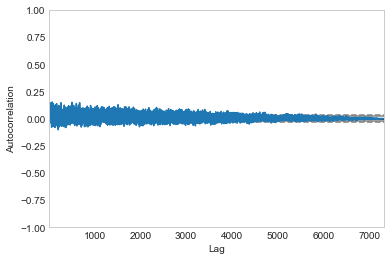

In [46]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df.Systolic)


In [47]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tqdm import tqdm_notebook

%matplotlib inline


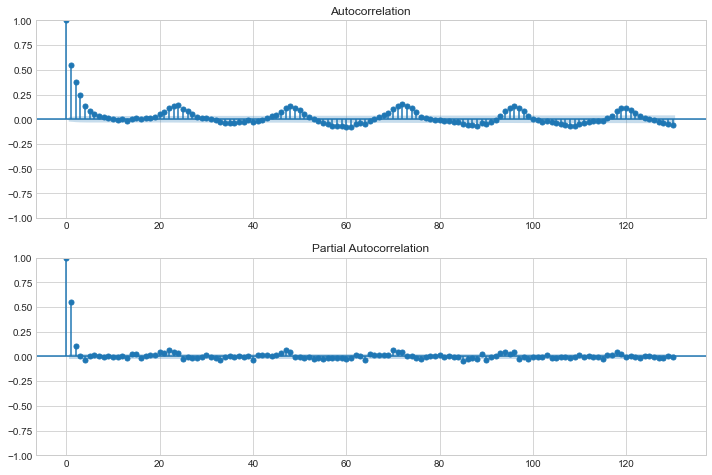

In [64]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df.Systolic, lags=130, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df.Systolic, lags=130, ax=ax2)

shows that the ACF plot decays and dies down in a damp sine-wave fashion while the PACF plot cuts off after the second lag, may have seasonality 

seasonality test

In [49]:
acorr_ljungbox(df.Systolic, lags=[24], return_df=True)


lb_stat  lb_pvalue
24  4402.031352        0.0

In [52]:
acorr_ljungbox(df.Systolic, lags=[24], return_df=True)


lb_stat  lb_pvalue
24  4402.031352        0.0

In [53]:
acorr_ljungbox(df.Systolic, lags=[24], return_df=True)


lb_stat  lb_pvalue
24  4402.031352        0.0

In [54]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

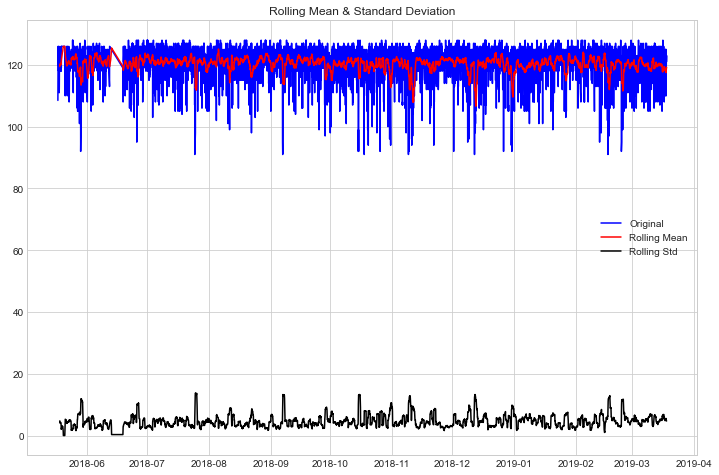

Results of Dickey-Fuller Test:
Test Statistic                -1.285868e+01
p-value                        5.166058e-24
#Lags Used                     3.200000e+01
Number of Observations Used    7.289000e+03
Critical Value (1%)           -3.431247e+00
Critical Value (5%)           -2.861937e+00
Critical Value (10%)          -2.566981e+00
dtype: float64


In [55]:
test_stationarity(df.Systolic)

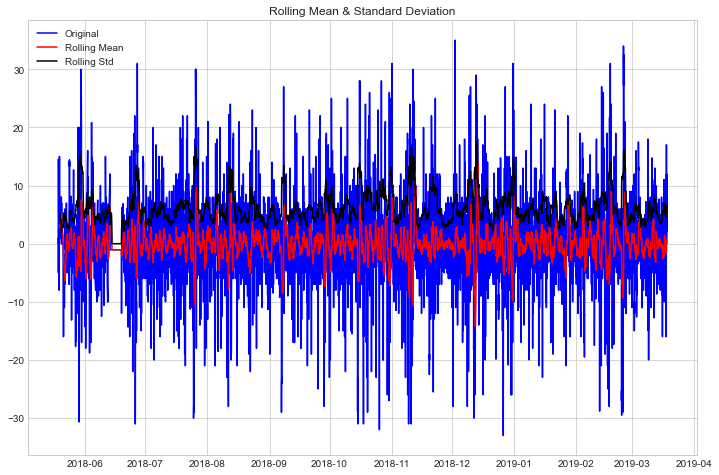

Results of Dickey-Fuller Test:
Test Statistic                -1.862652e+01
p-value                        2.059220e-30
#Lags Used                     3.000000e+01
Number of Observations Used    7.267000e+03
Critical Value (1%)           -3.431250e+00
Critical Value (5%)           -2.861938e+00
Critical Value (10%)          -2.566982e+00
dtype: float64


In [56]:
df['seasonal_difference'] = df.Systolic-df.Systolic.shift(24)
test_stationarity(df.seasonal_difference.dropna(inplace=False))

https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

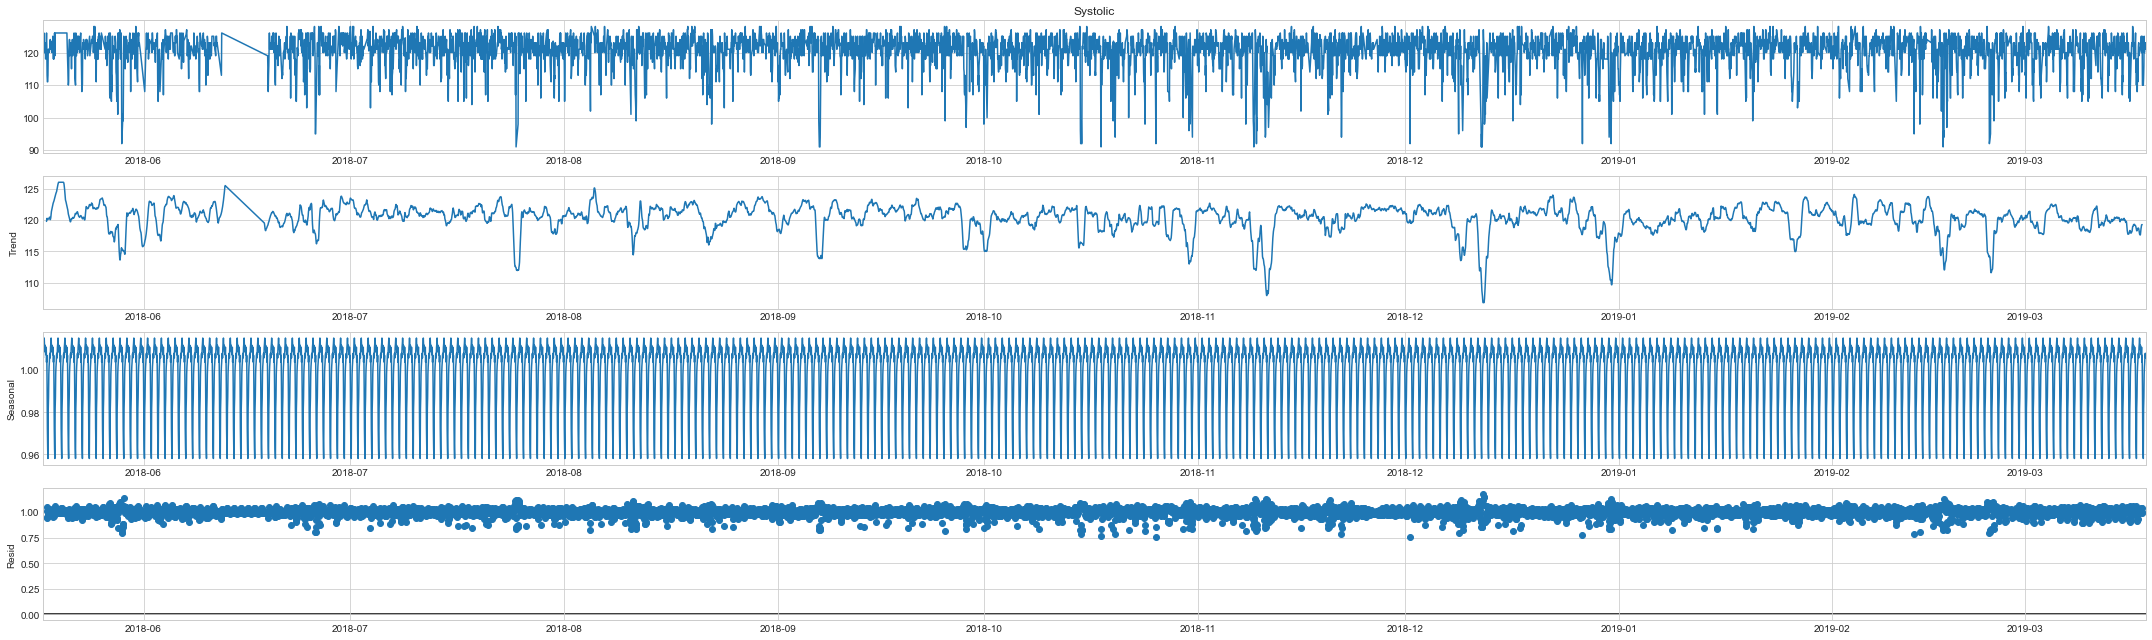

In [58]:
plt.rcParams["figure.figsize"] = [30,9]
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(df.Systolic, model='multiplicative',period=24)
result.plot()
pyplot.show()

<AxesSubplot:xlabel='Timestamp'>

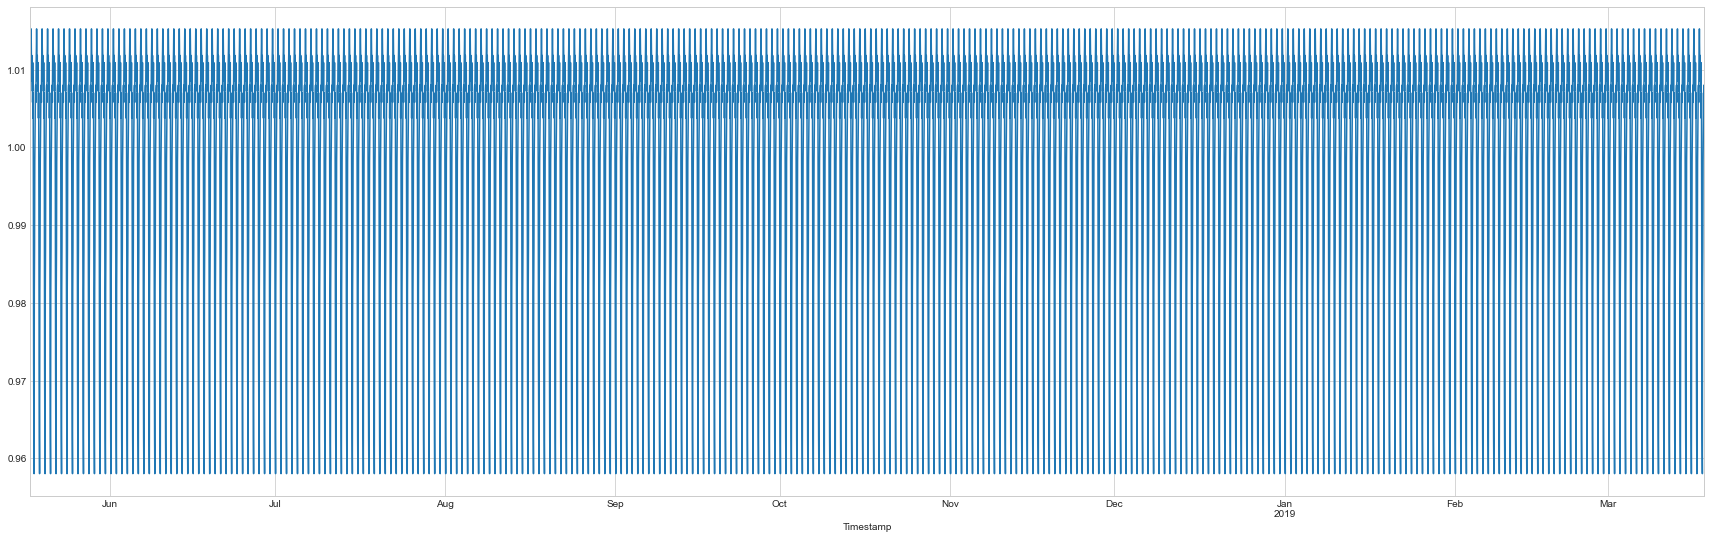

In [59]:
seasonality = result.seasonal
seasonality.plot()

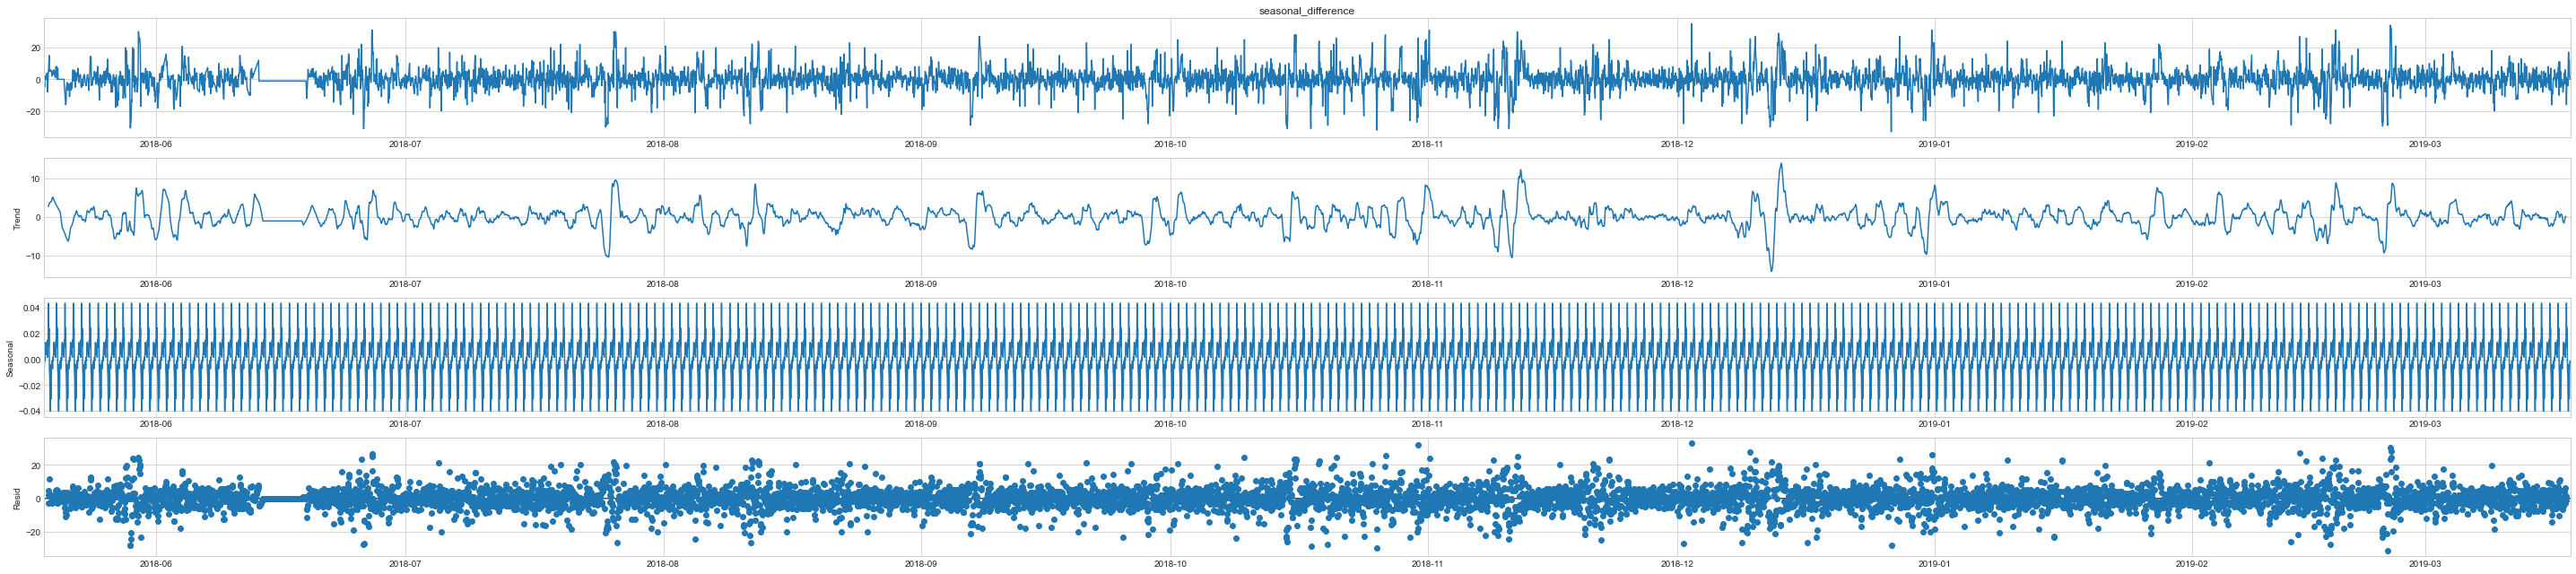

In [69]:
plt.rcParams["figure.figsize"] = [40,9]
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(df.seasonal_difference.iloc[25:], model='addictive',period=24)
result.plot()
pyplot.show()

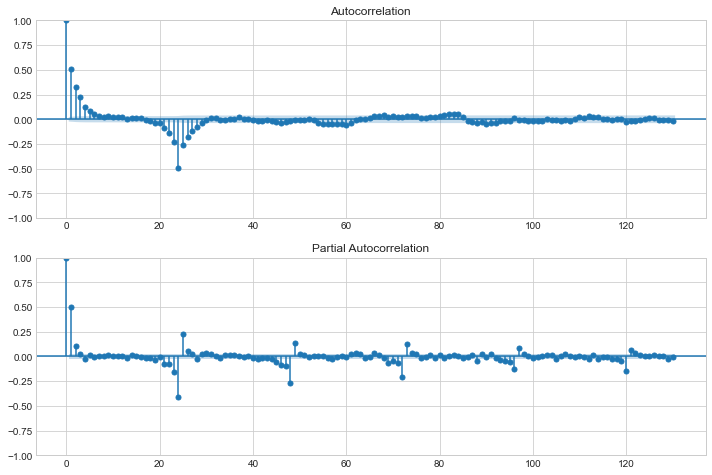

In [61]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df.seasonal_difference.iloc[25:], lags=130, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df.seasonal_difference.iloc[25:], lags=130, ax=ax2)

In [65]:
df['seasonal_difference_2'] = df.seasonal_difference-df.seasonal_difference.shift(24)
test_stationarity(df.seasonal_difference_2.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                  -20.602186
p-value                           0.000000
#Lags Used                       30.000000
Number of Observations Used    7243.000000
Critical Value (1%)              -3.431253
Critical Value (5%)              -2.861939
Critical Value (10%)             -2.566982
dtype: float64


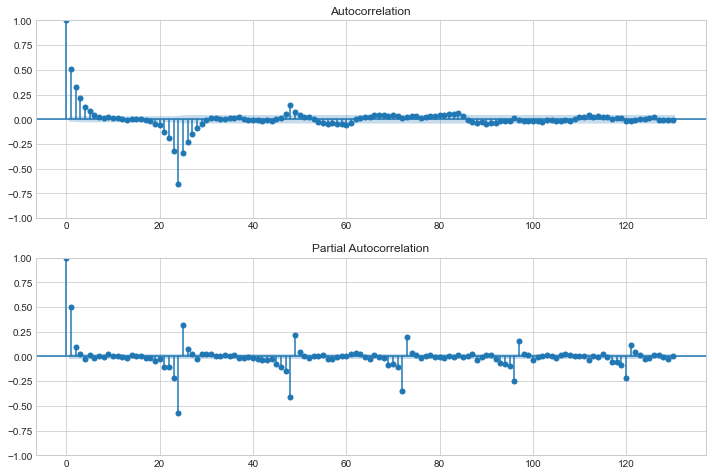

In [66]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df.seasonal_difference_2.iloc[49:], lags=130, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df.seasonal_difference_2.iloc[49:], lags=130, ax=ax2)

In [62]:
mod = SARIMAX(df.Systolic, trend='t', order=(0,0,0), seasonal_order=(1,1,1,24))
results = mod.fit()
print (results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             Systolic   No. Observations:                 7322
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 24)   Log Likelihood              -23284.994
Date:                              Wed, 17 Aug 2022   AIC                          46577.988
Time:                                      17:24:55   BIC                          46605.568
Sample:                                  05-17-2018   HQIC                         46587.472
                                       - 03-18-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       3.859e-11   1.14e-05   3.39e-06      1.000   -2.23e-05    2.23e-05
ar.S.L24      -0.21